# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import cv2
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Change directory

In [3]:
!pwd

/content


In [4]:
!ls 'gdrive/My Drive/Colab Notebooks/R9LabInternal /'

 AIML.H.Apr19-R10_Internal_Lab_Questions.ipynb
 images
 images_racoon-1.rar
'images_racoon-1.rar (Unzipped Files)'
 train_labels.csv


In [0]:
root_path = 'gdrive/My Drive/Colab Notebooks/R9LabInternal /'

In [0]:
os.chdir(root_path)

In [7]:
!pwd

/content/gdrive/My Drive/Colab Notebooks/R9LabInternal 


### Load the training data from train.csv file

In [8]:
df=pd.read_csv("train_labels.csv")
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127


### Print the shape of the train dataset

In [9]:
df.shape


(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE=128

In [11]:
!ls

 AIML.H.Apr19-R10_Internal_Lab_Questions.ipynb
 images
 images_racoon-1.rar
'images_racoon-1.rar (Unzipped Files)'
 train_labels.csv


### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
with open('train_labels.csv','r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile) - 1, 4))
    spamreader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(spamreader, None)
    for i,row in enumerate(spamreader):
        #print(row)
        for j, r in enumerate(row): # Parse row with seven entities
            #print(i)
            if((j!= 0) & (j!=3)):
                row[j] = int(r)
            
        #print(row)      
        path, width, height, class_, xmin, ymin, xmax, ymax = row
        paths.append(path)
        #print(i)
        coords[i,0] = xmin * IMAGE_SIZE / width
        coords[i,1] = ymin * IMAGE_SIZE / height
        coords[i,2] = xmax * IMAGE_SIZE / width # Normalize bounding box by image size
        coords[i,3] = ymax * IMAGE_SIZE / height

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [13]:
print (paths)

['raccoon-17.jpg', 'raccoon-11.jpg', 'raccoon-63.jpg', 'raccoon-63.jpg', 'raccoon-60.jpg', 'raccoon-69.jpg', 'raccoon-180.jpg', 'raccoon-200.jpg', 'raccoon-141.jpg', 'raccoon-19.jpg', 'raccoon-84.jpg', 'raccoon-124.jpg', 'raccoon-182.jpg', 'raccoon-111.jpg', 'raccoon-91.jpg', 'raccoon-79.jpg', 'raccoon-93.jpg', 'raccoon-20.jpg', 'raccoon-42.jpg', 'raccoon-139.jpg', 'raccoon-58.jpg', 'raccoon-71.jpg', 'raccoon-183.jpg', 'raccoon-1.jpg', 'raccoon-169.jpg', 'raccoon-82.jpg', 'raccoon-4.jpg', 'raccoon-101.jpg', 'raccoon-10.jpg', 'raccoon-166.jpg', 'raccoon-184.jpg', 'raccoon-38.jpg', 'raccoon-120.jpg', 'raccoon-142.jpg', 'raccoon-149.jpg', 'raccoon-51.jpg', 'raccoon-43.jpg', 'raccoon-123.jpg', 'raccoon-66.jpg', 'raccoon-9.jpg', 'raccoon-178.jpg', 'raccoon-47.jpg', 'raccoon-167.jpg', 'raccoon-54.jpg', 'raccoon-77.jpg', 'raccoon-155.jpg', 'raccoon-89.jpg', 'raccoon-153.jpg', 'raccoon-179.jpg', 'raccoon-115.jpg', 'raccoon-64.jpg', 'raccoon-56.jpg', 'raccoon-44.jpg', 'raccoon-39.jpg', 'raccoon

In [14]:
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.backend import epsilon   #to get the metrics for IoU


Using TensorFlow backend.


In [0]:
from PIL import Image as PImage
#
batch_images= np.zeros((len(paths),IMAGE_SIZE,IMAGE_SIZE,3),dtype=np.float32)
for i, x in enumerate(paths):
  img = PImage.open("images/images/"+x )
  img=img.resize((IMAGE_SIZE,IMAGE_SIZE))
  img.mode='RGB'
  batch_images[i]=preprocess_input(np.array(img,dtype=np.float32))


### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [16]:
model=MobileNet(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3), include_top=False,alpha=1)

In [17]:
model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32) 

In [18]:
import keras
from keras import Model
for layer in model.layers:
    layer.trainable=False

T=model.layers[-1].output
T=keras.layers.Conv2D(4,kernel_size=4,name='Conv2D_layer_N')(T)
T=keras.layers.Reshape((4,))(T) 

model=Model(input=model.input,output=T)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("re...)`
  # Remove the CWD from sys.path while we load stuff.


In [19]:
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [21]:
model.compile(optimizer='Adam',loss='mse',metrics=[IoU])


Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [22]:
model.fit(batch_images,coords,epochs=30,verbose=1,batch_size=32)





Epoch 1/30
173/173 [==============================] - 5s 30ms/step - loss: 4339.0311 - IoU: 0.0522
Epoch 2/30
173/173 [==============================] - 5s 26ms/step - loss: 975.0766 - IoU: 0.3539
Epoch 3/30
173/173 [==============================] - 4s 26ms/step - loss: 416.8225 - IoU: 0.5652
Epoch 4/30
173/173 [==============================] - 4s 26ms/step - loss: 629.1211 - IoU: 0.5349
Epoch 5/30
173/173 [==============================] - 5s 26ms/step - loss: 441.8346 - IoU: 0.5884
Epoch 6/30
173/173 [==============================] - 4s 26ms/step - loss: 223.4121 - IoU: 0.6560
Epoch 7/30
173/173 [==============================] - 5s 26ms/step - loss: 210.9722 - IoU: 0.6383
Epoch 8/30
173/173 [==============================] - 4s 26ms/step - loss: 192.4532 - IoU: 0.6628
Epoch 9/30
173/173 [==============================] - 5s 26ms/step - loss: 154.5169 - IoU: 0.7056
Epoch 10/30
173/173 [==============================] - 4s 26ms/step - loss: 140.1785 - IoU: 0.7269
Epoch 11/30
173/

### Pick a test image from the given data

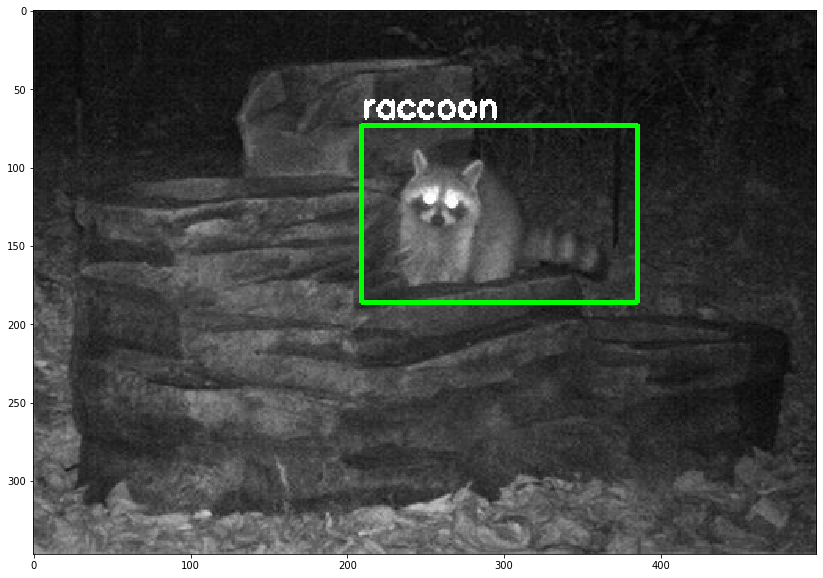

In [23]:
import cv2
#Pickup a random image number
img_num = np.random.randint(0, df.shape[0])

#Read the image
img_file = df.loc[img_num,'filename']
img = cv2.imread('images/images/' + img_file)
#Find all rows which have same file name
rows_with_file = df[df['filename'] == img_file].index.tolist()

#Draw rectangle(s) as per bounding box information
for i in rows_with_file:
    #Get bounding box
    xmin, ymin, xmax, ymax = df.loc[i, ['xmin', 'ymin', 'xmax', 'ymax']]
    #Get Label
    label = df.loc[i, 'class']
    #Add bounding box
    cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (0,255,0), 2)
    #Add text
    cv2.putText(img,label,(xmin, ymin-5),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

#Draw image using matplotlib
plt.figure(figsize=(15,10))
plt.imshow(img)
plt.show()

In [24]:
img.shape


(347, 500, 3)

In [0]:
import cv2 
img_file = "raccoon-1.jpg"
unscaled = cv2.imread( img_file)

In [26]:
img.shape

(347, 500, 3)

In [0]:
image_height, image_width,_ = img.shape

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [28]:
img2 = cv2.resize (img, (IMAGE_SIZE, IMAGE_SIZE))
scaled = preprocess_input (np.array(img2, dtype = np.float32))
scaled.shape

(128, 128, 3)

### Predict the coordinates of the bounding box for the given test image

In [29]:
np.array(scaled[0])

array([[-0.8117647 , -0.8117647 , -0.8117647 ],
       [-0.7647059 , -0.7647059 , -0.7647059 ],
       [-0.81960785, -0.81960785, -0.81960785],
       [-0.7882353 , -0.7882353 , -0.7882353 ],
       [-0.84313726, -0.84313726, -0.84313726],
       [-0.77254903, -0.77254903, -0.77254903],
       [-0.84313726, -0.84313726, -0.84313726],
       [-0.8745098 , -0.8745098 , -0.8745098 ],
       [-0.8117647 , -0.8117647 , -0.8117647 ],
       [-0.77254903, -0.77254903, -0.77254903],
       [-0.7019608 , -0.7019608 , -0.7019608 ],
       [-0.85882354, -0.85882354, -0.85882354],
       [-0.8745098 , -0.8745098 , -0.8745098 ],
       [-0.81960785, -0.81960785, -0.81960785],
       [-0.8352941 , -0.8352941 , -0.8352941 ],
       [-0.827451  , -0.827451  , -0.827451  ],
       [-0.8117647 , -0.8117647 , -0.8117647 ],
       [-0.8117647 , -0.8117647 , -0.8117647 ],
       [-0.77254903, -0.77254903, -0.77254903],
       [-0.8352941 , -0.8352941 , -0.8352941 ],
       [-0.79607844, -0.79607844, -0.796

In [30]:
region = model.predict(np.array([scaled]))[0]
region

array([32.77044 , 20.433739, 96.48462 , 89.99365 ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

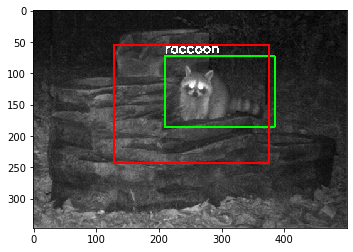

In [31]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()